In [1]:
# Imports

import os

import nltk

from cltk.corpus.latin import latinlibrary

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS

import matplotlib.pyplot as plt

import pickle

from pprint import pprint

In [2]:
# Load pickled lemmatizer

Lemmatizer = pickle.load(open("./tools/lemmatizer.p", "rb"))

In [3]:
# Load TextArray

TextArray = pickle.load(open("./data/text_array.p", "rb"))

In [4]:
# Example of TextArray record

print(f'{TextArray[1][0]},\n{TextArray[1][1]},\n{TextArray[1][2][:1000]}')

prose,
caesar/bc1.txt,
gratiam sequantur ut superioribus fecerint temporibus se sibi consilium capturum neque senatus auctoritati obtemperaturum habere se quoque ad caesaris gratiam atque amicitiam receptum in eandem sententiam loquitur scipio pompeio esse in animo rei publicae non deesse si senatus sequatur si cunctetur atque agat lenius nequiquam eius auxilium si postea uelit senatum imploraturum
haec scipionis oratio quod senatus in urbe habebatur pompeiusque aberat ex ipsius ore pompei mitti uidebatur dixerat aliquis leniorem sententiam ut primo m marcellus ingressus in eam orationem non oportere ante de ea re ad senatum referri quam dilectus tota italia habiti et exercitus conscripti essent quo praesidio tuto et libere senatus quae uellet decernere auderet ut m calidius qui censebat ut pompeius in suas prouincias proficisceretur ne qua esset armorum causa timere caesarem ereptis ab eo duabus legionibus ne ad eius periculum reseruare et retinere eas ad urbem pompeius uideretur ut m

In [5]:
#Script for lemmatizing texts

def get_lemmatized_text(text):
    tokens = text.split()
    lemma_list = Lemmatizer.lemmatize(tokens)
    lemmas = [lemma[1] for lemma in lemma_list]
    return " ".join(lemmas).replace('1','').replace('2','')

In [6]:
# Get data about TextArray
labels = [type for type, _, _ in TextArray]
titles = [title.replace('/', '_').replace('.txt','') for _, title, _ in TextArray]

prose_indices, verse_indices = [], []

for i, item in enumerate(TextArray):
    if item[0] == "prose":
        prose_indices.append(i)
    elif item[0] == "verse":
        verse_indices.append(i)

# Lemmatize texts

#texts = [get_lemmatized_text(text) for _, _, text in TextArray] # Pickled to save time in presentation
texts = pickle.load(open("./data/text_array_lemmatized.p", "rb"))

In [7]:
# Create document-term matrix
vectorizer = CountVectorizer(input='content')
dtm = vectorizer.fit_transform(texts)
vocab = np.array(vectorizer.get_feature_names())
dtm = dtm.toarray()
dtm

array([[ 89,   0,   0, ...,   0,   0,   0],
       [151,   0,   0, ...,   0,   0,   0],
       [ 64,   0,   0, ...,   0,   0,   0],
       ...,
       [ 18,   0,   0, ...,   0,   0,   0],
       [ 23,   0,   0, ...,   0,   0,   0],
       [ 24,   0,   0, ...,   0,   0,   0]], dtype=int64)

In [8]:
# Show dimensions of dtm

dtm.shape

(137, 28504)

In [9]:
# Show extract of data from dtm

text_array_df = pd.DataFrame(dtm, columns=vocab, index=titles)
text_array_df.iloc[[0,25,50,100,123],:10]

,ab,abacorum,abacus,abalieno,abantem,abantiades,abantis,abarimque,abarin,abas
caesar_alex,89,0,0,0,0,0,0,0,0,0
livy_liv.24,168,0,0,0,0,0,0,0,0,0
vergil_aen11,16,0,0,0,0,0,0,0,0,0
ovid_ovid.her19,5,0,0,0,0,0,0,0,0,0
ovid_ovid.met6,23,0,0,0,0,0,0,0,0,0


In [10]:
# Work lengths

print(f'{titles[0]} is {np.sum(dtm, axis=1)[0]} words long.')
print(f'{titles[25]} is {np.sum(dtm, axis=1)[25]} words long.')

caesar_alex is 10239 words long.
livy_liv.24 is 13878 words long.


In [11]:
# Normalize word counts to be 'per 1000 words'

rates = 1000 * dtm / np.sum(dtm, axis=1, keepdims=True)
rates_df = pd.DataFrame(rates, columns=vocab, index=titles)
rates_df.iloc[[0,25,50,100,125,136],:10]

,ab,abacorum,abacus,abalieno,abantem,abantiades,abantis,abarimque,abarin,abas
caesar_alex,8.692255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
livy_liv.24,12.105491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vergil_aen11,2.820377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ovid_ovid.her19,4.512635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ovid_ovid.met8,5.414488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ovid_ovid.tristia5,5.159071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Show keyness

In [12]:
# Get keyness using chi-square test

from sklearn.feature_selection import chi2
keyness, _ = chi2(dtm, labels)

In [13]:
# Sort by keyness

ranking = np.argsort(keyness)[::-1]
pprint(list(zip(ranking[0:10], vocab[ranking][0:10])))

[(13640, 'is'),
 (21598, 'qui'),
 (12499, 'in'),
 (24811, 'sum'),
 (359, 'ad'),
 (9142, 'et'),
 (6723, 'cum'),
 (0, 'ab'),
 (9389, 'ex'),
 (2784, 'atque')]


In [14]:
# Reduce dimensionality to 2 dimensions using MDS 

dist = 1 - cosine_similarity(dtm)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

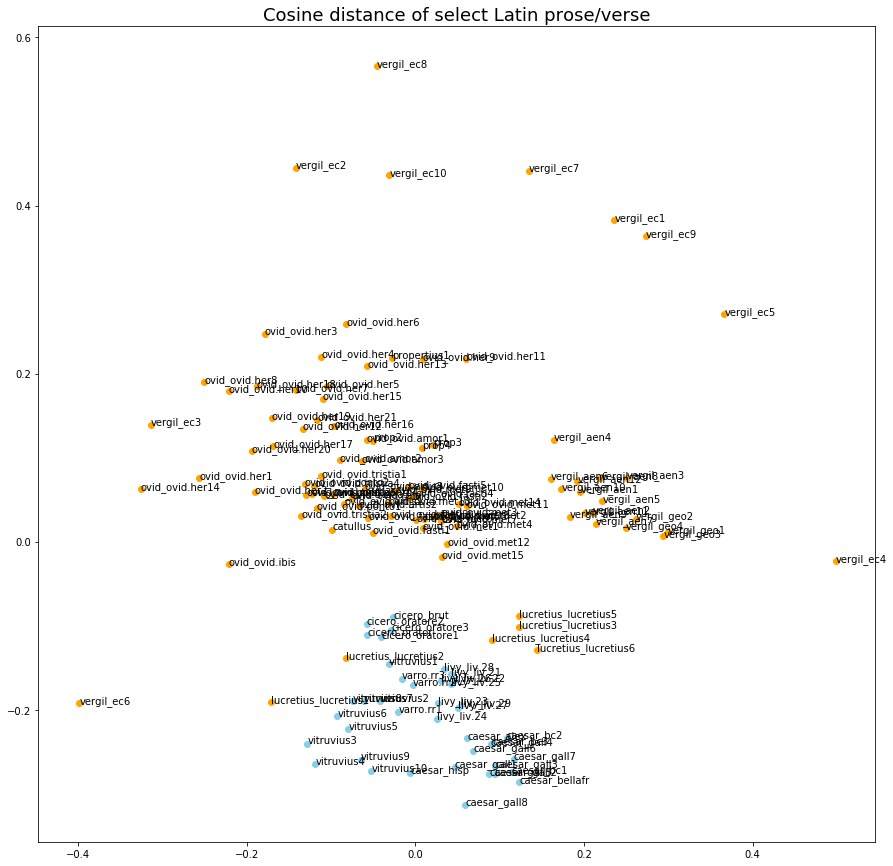

In [15]:
# Plot cosine distance

xs, ys = pos[:, 0], pos[:, 1]

names = [os.path.basename(fn).replace('.txt', '') for fn in titles]

plt.figure(figsize=(15,15))
for x, y, title, label in zip(xs, ys, titles, labels):
    color = 'orange' if label == 'verse' else 'skyblue'
    plt.scatter(x, y, c=color)
    plt.text(x, y, title)


plt.title("Cosine distance of select Latin prose/verse", fontsize=18)
plt.show()

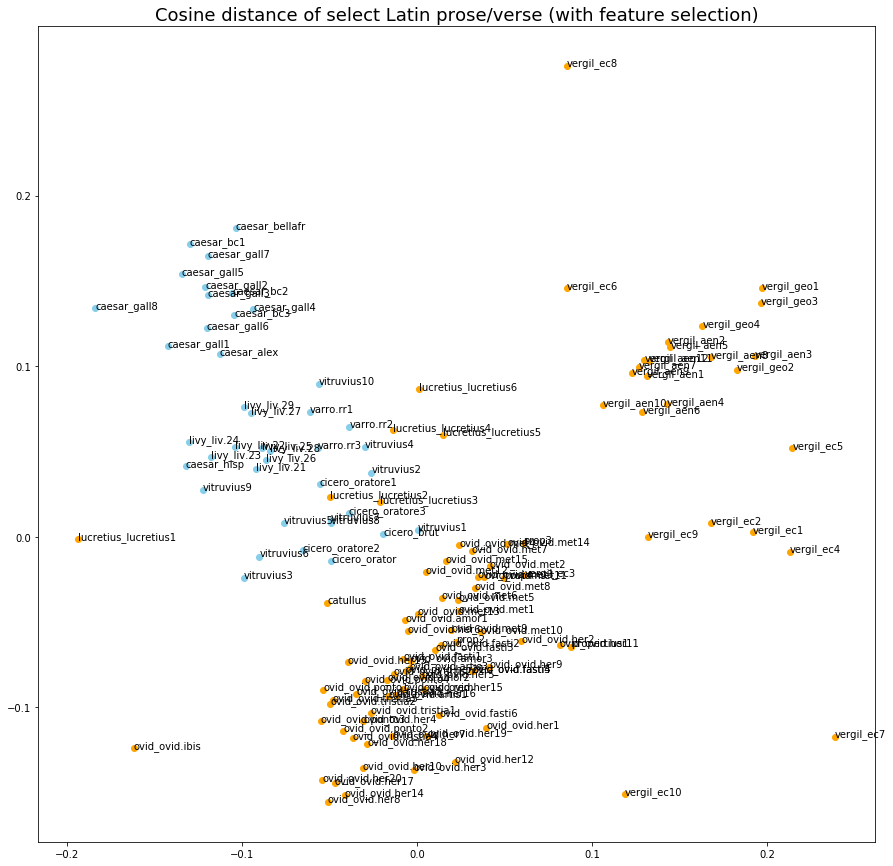

In [16]:
# Plot cosine distance of reduced featureset

selected = np.argsort(keyness)[::-1][:50]
dtm_chi2 = dtm[:, selected]
dist = 1 - cosine_similarity(dtm_chi2)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

plt.figure(figsize=(15,15))
for x, y, title, label in zip(xs, ys, titles, labels):
    color = 'orange' if label == 'verse' else 'skyblue'
    plt.scatter(x, y, c=color)
    plt.text(x, y, title)

plt.title("Cosine distance of select Latin prose/verse (with feature selection)", fontsize=18)
plt.show()

In [17]:
# Look at counts for 'key' vocabulary

rates_df.iloc[:10,selected[:10]]

,is,qui,in,sum,ad,et,cum,ab,ex,atque
caesar_alex,18.947163,30.569392,25.393105,25.100107,13.282547,20.021486,13.575544,8.692255,8.399258,10.743237
caesar_bc1,19.277559,29.758563,22.646453,18.341756,15.534344,18.996818,9.732360,14.130638,9.732360,16.750889
caesar_bc2,15.744197,29.216036,20.938159,19.964292,15.906509,19.477358,8.602500,10.387924,13.634150,14.121084
caesar_bc3,21.253627,26.786317,19.162000,23.885028,16.395655,22.805479,10.660549,11.875042,11.672627,12.954591
caesar_bellafr,20.310913,23.123194,25.701117,19.139130,13.827045,22.263886,15.858136,14.139520,9.374268,12.342786
caesar_gall1,34.651601,34.777150,22.096673,27.997489,13.810421,23.979912,11.048336,12.806026,7.281858,9.165097
caesar_gall2,23.936847,31.321620,27.501910,21.899669,17.061370,22.154316,14.005602,15.788133,10.949834,14.514897
caesar_gall3,22.004163,33.303598,24.382991,21.706809,14.570324,19.327981,12.488849,8.920607,10.704728,17.246506
caesar_gall4,24.295210,39.422416,25.899610,25.441210,18.565207,27.045611,12.147605,11.001604,11.460005,16.044006
caesar_gall5,23.670287,26.872737,25.062657,21.164021,18.518519,18.379282,13.505987,12.392091,11.695906,14.619883


In [18]:
rates_df.iloc[-10:,selected[:10]]

,is,qui,in,sum,ad,et,cum,ab,ex,atque
ovid_ovid.ponto1,2.518892,24.559194,12.804366,39.252729,5.037783,15.952981,8.816121,5.667506,1.679261,0.629723
ovid_ovid.ponto2,1.699958,22.311942,11.049724,47.811305,4.037399,18.274543,7.012325,6.799830,0.000000,1.699958
ovid_ovid.ponto3,2.638522,20.888303,12.093228,42.216359,5.936675,14.291996,6.376429,5.936675,1.539138,0.659631
ovid_ovid.ponto4,1.721467,24.272680,12.738854,42.692374,4.992253,20.141160,5.852987,5.680840,1.032880,1.721467
ovid_ovid.rem,1.003613,20.272983,13.247692,44.359695,4.014452,25.491770,5.018065,3.412284,1.405058,1.003613
ovid_ovid.tristia1,2.009377,18.977450,15.181960,43.313240,2.679169,18.530922,4.018754,6.697924,1.116321,0.669792
ovid_ovid.tristia2,2.661934,21.887016,12.718131,40.224786,2.070393,16.267377,6.802721,4.732328,0.591541,0.887311
ovid_ovid.tristia3,3.515302,20.885029,16.749380,42.803970,2.481390,18.610422,5.376344,3.722084,1.654260,1.240695
ovid_ovid.tristia4,1.209775,23.227680,14.033390,50.326639,2.903460,18.630535,6.774740,5.564965,1.209775,0.725865
ovid_ovid.tristia5,0.859845,26.225279,15.907137,42.562339,3.224420,16.766982,6.878762,5.159071,0.644884,2.149613


In [19]:
rates_df.iloc[:10,selected[-10:]]

,eques,itaque,possum,pars,dies,nauis,hannibal,copia,orator,reliquus
caesar_alex,1.171989,1.757984,6.055279,5.859947,2.050982,7.422600,0.0,3.515968,0.0000,2.636976
caesar_bc1,3.275313,1.216545,4.772600,3.556055,4.959760,3.649635,0.0,2.245929,0.0000,3.930376
caesar_bc2,3.570849,1.785424,6.167830,3.570849,2.921604,7.304009,0.0,3.408538,0.0000,2.921604
caesar_bc3,2.901289,1.147021,5.060387,3.306120,4.655556,5.667634,0.0,2.496458,0.0000,3.778423
caesar_bellafr,6.561987,2.265448,3.437231,4.296539,3.671588,4.687134,0.0,7.108820,0.0000,2.656042
caesar_gall1,1.381042,0.753296,7.909605,3.138732,4.645323,0.251099,0.0,3.515380,0.0000,2.510986
caesar_gall2,2.291826,0.509295,8.403361,6.366183,2.037179,0.000000,0.0,3.565062,0.0000,4.329004
caesar_gall3,1.189414,1.784121,6.244425,5.055010,2.081475,8.325899,0.0,3.270889,0.0000,4.757657
caesar_gall4,3.438001,1.604401,7.334403,7.334403,4.813202,8.022003,0.0,1.833601,0.2292,5.042402
caesar_gall5,3.063214,0.974659,6.126427,6.265664,5.291005,3.620162,0.0,3.480925,0.0000,2.367029


In [20]:
rates_df.iloc[-10:,selected[-10:]]

,eques,itaque,possum,pars,dies,nauis,hannibal,copia,orator,reliquus
ovid_ovid.ponto1,0.209908,0.0,6.717045,2.938707,0.629723,0.419815,0.0,0.000000,0.209908,0.209908
ovid_ovid.ponto2,0.000000,0.0,6.374841,2.337442,1.274968,0.637484,0.0,0.212495,0.000000,0.000000
ovid_ovid.ponto3,0.000000,0.0,6.156552,2.638522,0.219877,0.439754,0.0,0.439754,0.000000,0.219877
ovid_ovid.ponto4,0.344293,0.0,6.197280,3.098640,1.549320,0.516440,0.0,0.344293,0.000000,0.000000
ovid_ovid.rem,0.000000,0.0,8.831794,2.408671,0.602168,0.802890,0.0,0.200723,0.000000,0.000000
ovid_ovid.tristia1,0.000000,0.0,5.581603,2.232641,0.669792,0.446528,0.0,0.223264,0.000000,0.223264
ovid_ovid.tristia2,0.887311,0.0,6.506951,4.732328,0.887311,0.000000,0.0,0.000000,0.000000,0.000000
ovid_ovid.tristia3,0.000000,0.0,7.444169,2.688172,0.413565,0.206782,0.0,0.000000,0.000000,0.000000
ovid_ovid.tristia4,0.483910,0.0,3.871280,2.903460,1.451730,0.483910,0.0,0.000000,0.000000,0.000000
ovid_ovid.tristia5,0.000000,0.0,6.663801,4.299226,1.934652,0.644884,0.0,0.000000,0.000000,0.000000


In [21]:
rates_df.loc[:,['uxor','coniunx']][:10]

,uxor,coniunx
caesar_alex,0.000000,0.000000
caesar_bc1,0.000000,0.000000
caesar_bc2,0.162311,0.000000
caesar_bc3,0.067472,0.000000
caesar_bellafr,0.000000,0.234357
caesar_gall1,0.251099,0.000000
caesar_gall2,0.000000,0.000000
caesar_gall3,0.000000,0.000000
caesar_gall4,0.229200,0.000000
caesar_gall5,0.139237,0.000000


In [22]:
rates_df.loc[:,['uxor','coniunx']][-10:]

,uxor,coniunx
ovid_ovid.ponto1,0.209908,1.049538
ovid_ovid.ponto2,0.212495,0.424989
ovid_ovid.ponto3,1.099384,1.099384
ovid_ovid.ponto4,0.000000,0.344293
ovid_ovid.rem,0.401445,1.405058
ovid_ovid.tristia1,1.116321,0.893056
ovid_ovid.tristia2,0.295770,0.295770
ovid_ovid.tristia3,0.000000,1.240695
ovid_ovid.tristia4,0.725865,1.693685
ovid_ovid.tristia5,0.214961,1.074807


## Working with collapsed prose/verse data

In [23]:
prose_index = [i for i, item in enumerate(TextArray) if item[0] == 'prose']
verse_index = [i for i, item in enumerate(TextArray) if item[0] == 'verse']

In [24]:
p_sum = text_array_df.iloc[prose_index].sum().tolist()
v_sum = text_array_df.iloc[verse_index].sum().tolist()

In [25]:
type_df = pd.DataFrame(list(zip(p_sum, v_sum)), columns = ['prose', 'verse'], index=vocab)

In [26]:
prose_count = type_df['prose'].sum()
verse_count = type_df['verse'].sum()
print(f"There are {prose_count} prose words.")
print(f"There are {verse_count} verse words.")

There are 442793 prose words.
There are 365936 verse words.


In [27]:
type_df['prose_rates'] = 1000 * (type_df['prose'] / prose_count)
type_df['verse_rates'] = 1000 * (type_df['verse'] / verse_count)

In [28]:
type_df['poeticness'] = type_df['verse_rates'] / (type_df['prose_rates'] + type_df['verse_rates'])

In [29]:
from sklearn.preprocessing import minmax_scale
type_df['keyness_scaled'] = minmax_scale(keyness)

In [30]:
type_df.sort_values(['keyness_scaled'], ascending=[0])[:10]

,prose,verse,prose_rates,verse_rates,poeticness,keyness_scaled
is,8727,743,19.708984,2.030410,0.093398,1.000000
qui,12819,6697,28.950322,18.301014,0.387312,0.680482
in,11424,5413,25.799866,14.792204,0.364411,0.660348
sum,14869,10154,33.580025,27.748022,0.452452,0.593617
ad,6188,1644,13.974927,4.492589,0.243270,0.514530
et,11917,9548,26.913253,26.091994,0.492253,0.383358
cum,5345,2239,12.071103,6.118556,0.336376,0.340077
ab,4352,1567,9.828520,4.282170,0.303470,0.306824
ex,3208,651,7.244920,1.779000,0.197143,0.297881
atque,3954,1420,8.929680,3.880460,0.302921,0.279219


In [31]:
type_df.loc['coniunx']

prose              23.000000
verse             329.000000
prose_rates         0.051943
verse_rates         0.899064
poeticness          0.945381
keyness_scaled      0.005253
Name: coniunx, dtype: float64

In [32]:
type_df.loc['uxor']

prose             32.000000
verse             64.000000
prose_rates        0.072269
verse_rates        0.174894
poeticness         0.707607
keyness_scaled     0.000030
Name: uxor, dtype: float64

In [33]:
type_df.loc['is']

prose             8727.000000
verse              743.000000
prose_rates         19.708984
verse_rates          2.030410
poeticness           0.093398
keyness_scaled       1.000000
Name: is, dtype: float64

In [34]:
type_df.loc['et']

prose             11917.000000
verse              9548.000000
prose_rates          26.913253
verse_rates          26.091994
poeticness            0.492253
keyness_scaled        0.383358
Name: et, dtype: float64

## Mapping 'poeticness' in narrative space

In [35]:
# Script for preprocessing texts

import html
import re
import string
from cltk.stem.latin.j_v import JVReplacer

def preprocess(text):
    
    replacer = JVReplacer()
    
    text = html.unescape(text) # Handle html entities
    text = re.sub(r'&nbsp;?', ' ',text) #&nbsp; stripped incorrectly in corpus?
    text = re.sub(r'\x00',' ',text) #Another space problem?
        
    text = text.lower()
    text = replacer.replace(text) #Normalize u/v & i/j    
    
    punctuation ="\"#$%&\'()*+,-/:;<=>@[\]^_`{|}~.?!«»—"
    translator = str.maketrans({key: " " for key in punctuation})
    text = text.translate(translator)
    
    translator = str.maketrans({key: " " for key in '0123456789'})
    text = text.translate(translator)
    
    text = re.sub('[ ]+',' ', text) # Remove double spaces
    text = re.sub('\s+\n+\s+','\n', text) # Remove double lines and trim spaces around new lines
    
    return text.strip()

In [36]:
odes_tokens = get_lemmatized_text(preprocess("""Ne forte credas interitura quae
longe sonantem natus ad Aufidum
non ante volgatas per artis
verba loquor socianda chordis:
non, si priores Maeonius tenet
sedes Homerus, Pindaricae latent
Ceaeque et Alcaei minaces
Stesichorique graves Camenae

nec siquid olim lusit Anacreon
delevit aetas; spirat adhuc amor
vivuntque conmissi calores
Aeoliae fidibus puellae.

non sola comptos arsit adulteri
crinis et aurum vestibus inlitum
mirata regalisque cultus
et comites Helene Lacaena

primusve Teucer tela Cydonio
direxit arcu; non semel Ilios
vexata; non pugnavit ingens
Idomeneus Sthenelusve solus

dicenda Musis proelia; non ferox
Hector vel acer Deiphobus gravis
excepit ictus pro pudicis
coniugibus puerisque primus.

vixere fortes ante Agamemnona
multi; sed omnes inlacrimabiles
urgentur ignotique longa
nocte, carent quia vate sacro.

paullum sepultae distat inertiae
celata virtus. non ego te meis
chartis inornatum silebo,
totve tuos patiar labores

inpune, Lolli, carpere lividas
obliviones. est animus tibi
rerumque prudens et secundis
temporibus dubiisque rectus,

vindex avarae fraudis et abstinens
ducentis ad se cuncta pecuniae,
consulque non unius anni,
sed quotiens bonus atque fidus
iudex honestum praetulit utili,
reiecit alto dona nocentium
voltu, per obstantis catervas
explicuit sua victor arma.

non possidentem multa vocaveris
recte beatum; rectius occupat
nomen beati qui deorum
muneribus sapienter uti

duramque callet pauperiem pati
peiusque leto flagitium timet,
non ille pro caris amicis
aut patria timidus perire.""")).split()

In [37]:
print(odes_tokens[:100])

['ne', 'fors', 'credo', 'intereo', 'qui', 'longus', 'sono', 'nascor', 'ad', 'aufidum', 'non', 'ante', 'uolgatas', 'per', 'ars', 'uerbum', 'loquor', 'socio', 'chordus', 'non', 'si', 'prior', 'maeonius', 'teneo', 'sedes', 'homerus', 'pindaricae', 'lateo', 'ceaeque', 'et', 'alcaei', 'minax', 'stesichorique', 'grauis', 'camenae', 'neque', 'siquis', 'olim', 'ludo', 'anacreon', 'deleo', 'aetas', 'spiro', 'adhuc', 'amor', 'uiuuntque', 'con-mitto', 'calor', 'aeoliae', 'fides', 'puella', 'non', 'solus', 'como', 'ardeo', 'adulter', 'crinis', 'et', 'aurum', 'uestis', 'illitus', 'miro', 'regales', 'cultus', 'et', 'comes', 'helene', 'lacaena', 'primusue', 'teucer', 'telum', 'cydonius', 'dirigo', 'arcus', 'non', 'semel', 'ilios', 'vexo', 'non', 'pugno', 'ingens', 'idomeneus', 'sthenelusue', 'solus', 'dico', 'musis', 'proelio', 'non', 'ferox', 'hector', 'uel', 'acer', 'deiphobus', 'grauis', 'excipio', 'iacio', 'pro', 'pudicus', 'conjunx', 'puer']


In [38]:
odes_score = []

for token in odes_tokens:
    if token in vocab:
        odes_score.append(type_df.loc[token][4]-.5)
    else:
        odes_score.append(0)

print(odes_score[:25])

[-0.12755721825921995, 0.21768718285080935, 0.22245635982129663, 0.05411524938972401, -0.11268789999712531, 0.11841048122167486, 0.35284162381963013, 0.17327898311095868, -0.2567302057130316, -0.5, -0.028159059944731557, 0.03148464123539407, 0, 0.11824522548016736, -0.010642208947631238, 0.006139676844957864, 0.09327513441411939, 0.24610530067648706, 0.14476561351019845, -0.028159059944731557, -0.013022619428375903, 0.055930158835494126, 0, 0.16245111245358013, 0.3150116185607139]


In [39]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [40]:
odes_score_running = running_mean(odes_score, 25)

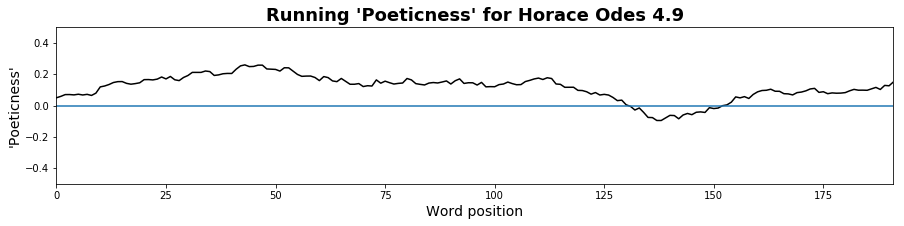

In [41]:
fig = plt.figure()
fig.set_size_inches(15,3)
ax = fig.add_subplot(111)
ax.plot(odes_score_running, color="k")

t =  plt.title('Running \'Poeticness\' for Horace Odes 4.9',fontsize = 18, fontweight = "bold")
#t.set_y(1.05)
fig.subplots_adjust(top=0.85)

ax.axhline(y=0)

#ax.xaxis.labelpad = 10 
#ax.yaxis.labelpad = 10 

ax.set_ylim(-.5,.5)
ax.set_xlim(0,len(odes_score_running)-1)

ax.set_xlabel('Word position', fontsize = 14)
ax.set_ylabel('\'Poeticness\'', fontsize = 14)
plt.show()

In [42]:
list(odes_score_running).index(min(odes_score_running))
" ".join(odes_tokens[142-12:142+13])

'totue tuus patior labor impunis lolli carpo liuidas obliuio sum animus tu res prudens et secundus tempus dubius rectus uindex avarus fraus et abstineo ducenti'

In [43]:
test = "sum animus tu res prudens et secundus tempus dubius rectus".split()
type_df.loc[test]

,prose,verse,prose_rates,verse_rates,poeticness,keyness_scaled
sum,14869,10154,33.580025,27.748022,0.452452,0.593617
animus,795,637,1.795421,1.740742,0.492268,0.025572
tu,1000,3739,2.258392,10.217634,0.818981,0.010066
res,2993,991,6.759366,2.708124,0.286045,0.221951
prudens,48,11,0.108403,0.030060,0.217097,0.004256
et,11917,9548,26.913253,26.091994,0.492253,0.383358
secundus,287,92,0.648158,0.251410,0.279479,0.021679
tempus,885,726,1.998677,1.983953,0.498152,0.027475
dubius,123,119,0.277782,0.325193,0.539314,0.002883
rectus,96,7,0.216806,0.019129,0.081078,0.011246


In [44]:
test = odes_tokens[184:]
type_df.loc[test]

,prose,verse,prose_rates,verse_rates,poeticness,keyness_scaled
non,4104,3030,9.268439,8.280136,0.471841,0.148201
possideo,14,25,0.031617,0.068318,0.683621,0.000038
multus,1495,1112,3.376295,3.038783,0.473694,0.053447
uoco,175,292,0.395219,0.797954,0.668767,0.000725
rectus,96,7,0.216806,0.019129,0.081078,0.011246
beatus,7,35,0.015809,0.095645,0.858159,0.000201
rectus,96,7,0.216806,0.019129,0.081078,0.011246
occupo,167,51,0.377151,0.139369,0.269822,0.012953
nomen,305,668,0.688809,1.825456,0.726039,0.000053
beati,1,4,0.002258,0.010931,0.828770,0.000013


In [45]:
def running_poeticness(tokens, window):
    scores = []

    for token in tokens:
        if token in vocab:
            scores.append(type_df.loc[token][4]-.5)
        else:
            scores.append(0)

    return running_mean(scores, window)


def plot_running_poeticness(running_scores, title, length=None):
    
    if not length:
        length = len(running_scores)-1
        
    fig = plt.figure()
    fig.set_size_inches(15,3)
    ax = fig.add_subplot(111)
    ax.plot(running_scores, color="k")

    t =  plt.title(f'Running \'Poeticness\' for {title}',fontsize = 18, fontweight = "bold")
    t.set_y(1.05)
    fig.subplots_adjust(top=0.85)

    ax.axhline(y=0)

    ax.xaxis.labelpad = 10 
    ax.yaxis.labelpad = 10 

    ax.set_ylim(-.5,.5)
    ax.set_xlim(0,length)

    ax.set_xlabel('Word position', fontsize = 14)
    ax.set_ylabel('\'Poeticness\'', fontsize = 14)
    plt.show()

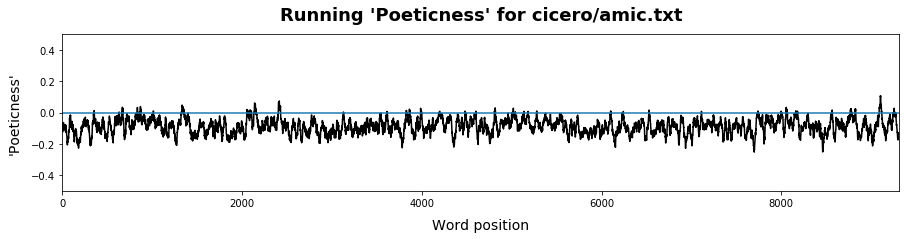

In [46]:
fileid = 'cicero/amic.txt'
tokens = get_lemmatized_text(preprocess(latinlibrary.raw(fileid))).split()
running_scores = running_poeticness(tokens, 25)
plot_running_poeticness(running_scores, fileid)

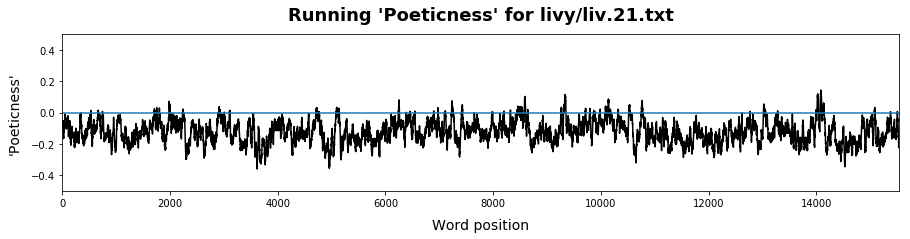

In [47]:
fileid = 'livy/liv.21.txt'
tokens = get_lemmatized_text(preprocess(latinlibrary.raw(fileid))).split()
running_scores = running_poeticness(tokens, 25)
plot_running_poeticness(running_scores, fileid)

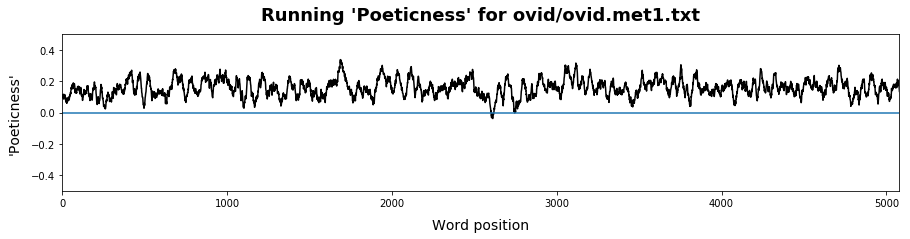

In [48]:
fileid = 'ovid/ovid.met1.txt'
tokens = get_lemmatized_text(preprocess(latinlibrary.raw(fileid))).split()
running_scores = running_poeticness(tokens, 25)
plot_running_poeticness(running_scores, fileid)

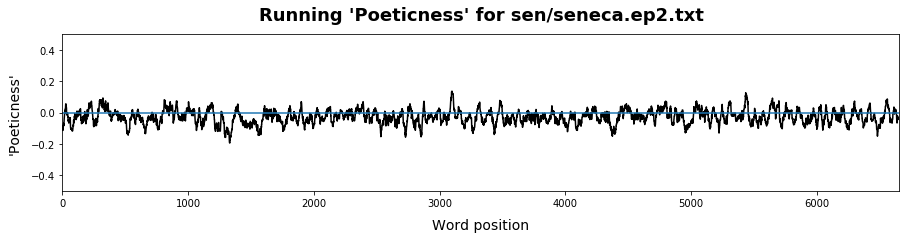

In [49]:
fileid = 'sen/seneca.ep2.txt'
tokens = preprocess(latinlibrary.raw(fileid)).split()
running_scores = running_poeticness(tokens, 25)
plot_running_poeticness(running_scores, fileid)

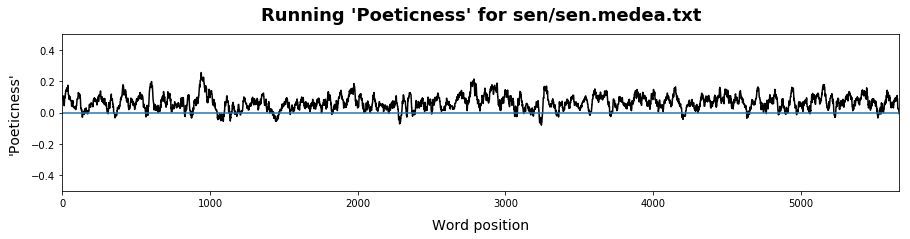

In [50]:
fileid = 'sen/sen.medea.txt'
tokens = preprocess(latinlibrary.raw(fileid)).split()
running_scores = running_poeticness(tokens, 25)
plot_running_poeticness(running_scores, fileid)

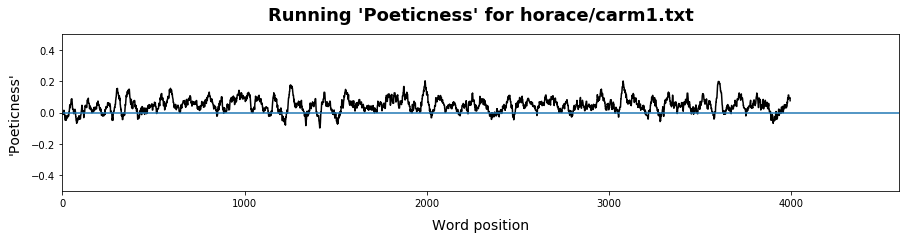

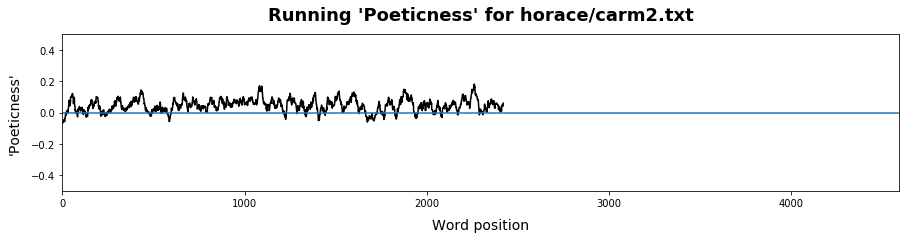

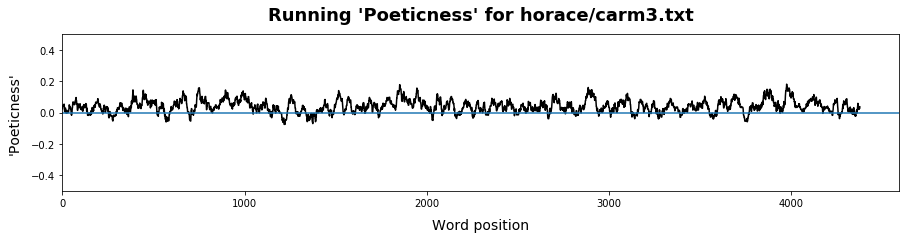

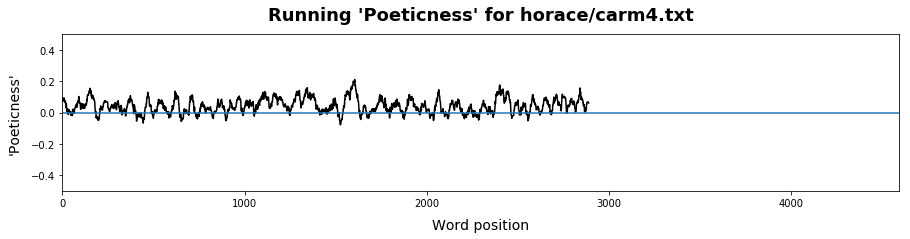

In [51]:
odes = [file for file in latinlibrary.fileids() if 'horace/carm' in file]
odes.remove('horace/carmsaec.txt')

length = max([len(latinlibrary.raw(text).split()) for text in odes])

for book in odes:
    tokens = preprocess(latinlibrary.raw(book)).split()
    running_scores = running_poeticness(tokens, 25)
    plot_running_poeticness(running_scores, book, length=length)

In [52]:
lucan = [file for file in latinlibrary.fileids() if 'lucan/' in file]
lucan = sorted(lucan, key=lambda x : int(" ".join(re.findall(r'\d+',x))))

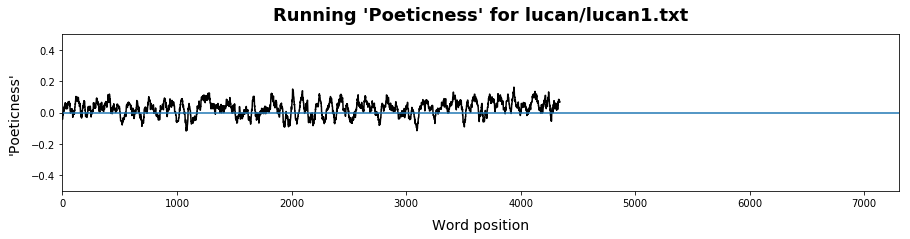

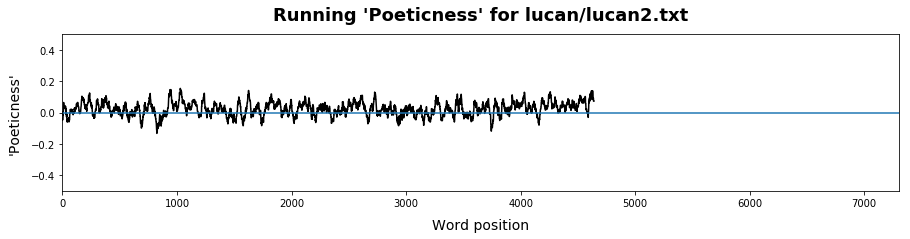

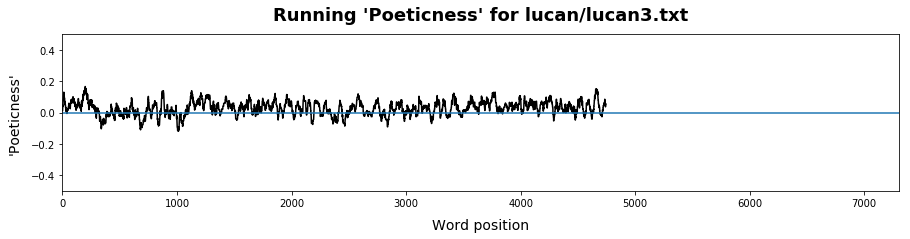

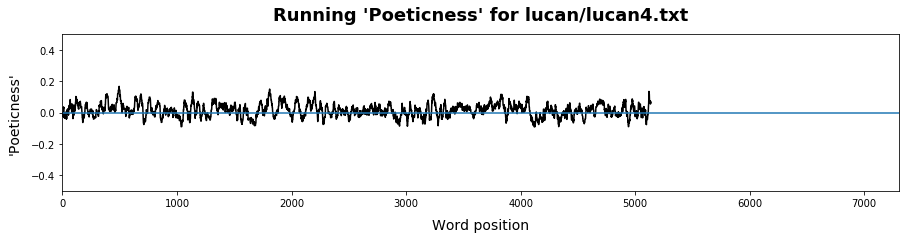

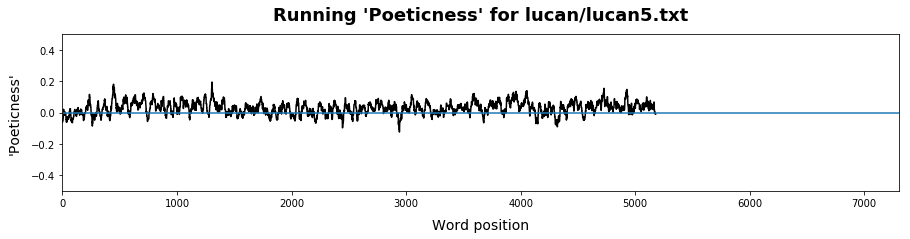

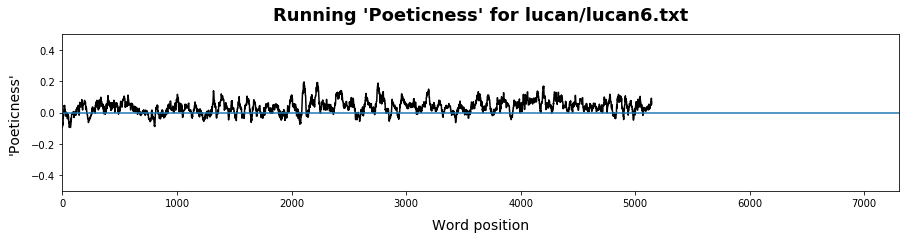

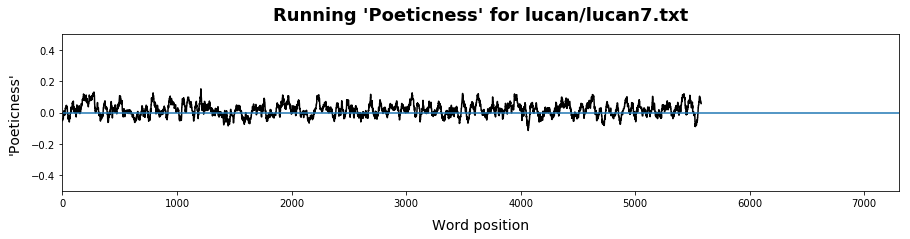

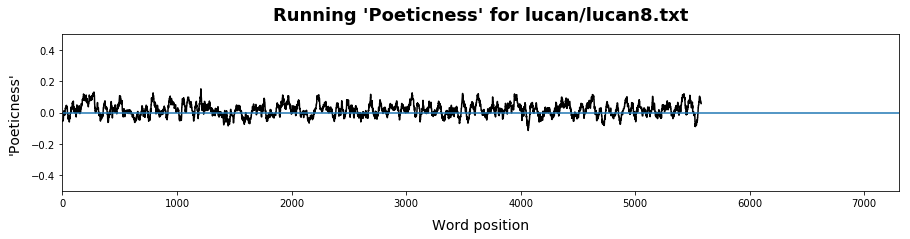

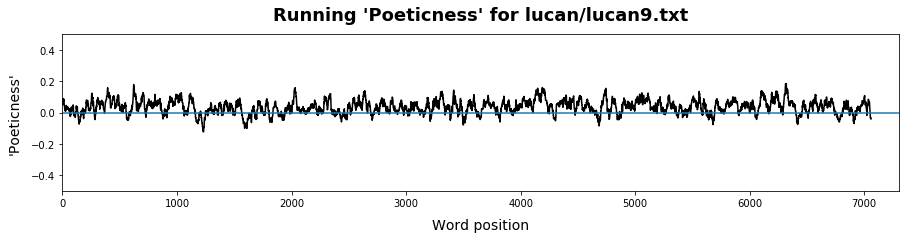

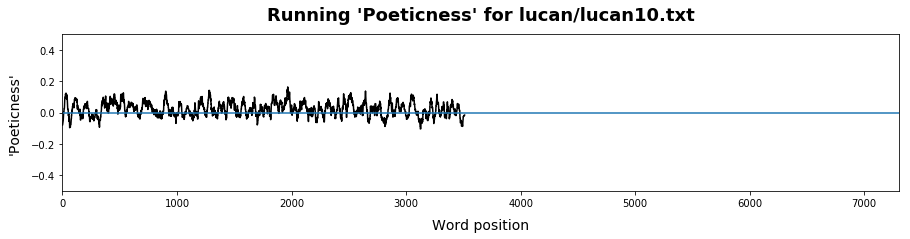

In [53]:
length = max([len(latinlibrary.raw(text).split()) for text in lucan])

for book in lucan:
    tokens = preprocess(latinlibrary.raw(book)).split()
    running_scores = running_poeticness(tokens, 25)
    plot_running_poeticness(running_scores, book, length=length)

## Neutral Words

In [54]:
type_df.loc['sol uir herba'.split()]

,prose,verse,prose_rates,verse_rates,poeticness,keyness_scaled
sol,199,329,0.449420,0.899064,0.666722,0.000868
uir,265,707,0.598474,1.932032,0.763496,0.000188
herba,39,225,0.088077,0.614862,0.874701,0.001653
